In [2]:
import re
import time
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. Needed to remove SettingWithCopyWarning warning when assigning new value to dataframe column
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import scipy.stats as stats

%load_ext autoreload
%autoreload 2

from housing_crawler.utils import save_file, get_file, crawl_ind_ad_page
from housing_crawler.analysis.ads_table_processing import get_processed_ads_table
from housing_crawler.string_utils import remove_prefix, simplify_address, standardize_characters, capitalize_city_name, german_characters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ads_feat_df = get_processed_ads_table()


ads_df = ads_feat_df#.drop(columns=['crawler','details_searched', 'cold_rent_euros',
#        'mandatory_costs_euros', 'extra_costs_euros', 'transfer_costs_euros',
#        'deposit', 'home_total_size', 'smoking', 'wg_type',
#        'age_range', 'gender_search', 'energy', 'wg_possible', 'building_type',
#        'building_floor', 'furniture', 'kitchen', 'shower_type', 'tv',
#        'floor_type', 'heating', 'public_transport_distance', 'internet',
#        'parking', 'schufa_needed', 'extras_waschmaschine',
#        'extras_spuelmaschine', 'extras_terrasse', 'extras_balkon',
#        'extras_garten', 'extras_gartenmitbenutzung', 'extras_keller',
#        'extras_aufzug', 'extras_haustiere', 'extras_fahrradkeller',
#        'extras_dachboden', 'languages_deutsch', 'languages_englisch',
#        'number_languages', 'min_age_flatmates', 'max_age_flatmates'])

===> Loaded all_encoded.csv locally
===> ads_OSM.csv saved locally


In [4]:
typeoffer_ads_df = ads_df[['url', 'type_offer_simple']].groupby('type_offer_simple').count().rename(columns={'url':'count'}).sort_values(by = ['count'], ascending=False)
typeoffer_ads_df

count
type_offer_simple       
WG                 43580
Apartment           8054
Single-room flat    7477

In [5]:
typeoffer_ads_df = ads_df[['url', 'type_offer_simple', 'city']].groupby(['type_offer_simple', 'city']).count().rename(columns={'url':'count'}).reset_index().sort_values(by = ['type_offer_simple','count'], ascending=False)
typeoffer_ads_df.head(50)

type_offer_simple               city  count
51                WG             Berlin   6103
68                WG            München   4031
59                WG            Hamburg   3207
72                WG          Stuttgart   2865
64                WG               Köln   2552
65                WG            Leipzig   1997
69                WG            Münster   1977
57                WG  Frankfurt am Main   1951
62                WG          Karlsruhe   1720
74                WG           Würzburg   1408
60                WG           Hannover   1349
61                WG         Heidelberg   1326
50                WG             Aachen   1324
53                WG             Bremen   1230
67                WG           Mannheim   1203
58                WG          Göttingen   1139
66                WG              Mainz   1110
52                WG               Bonn   1050
71                WG         Regensburg    967
70                WG           Nürnberg    945
56                WG         Düsseldorf    888
55                WG            Dresden    854
54                WG          Darmstadt    840
73                WG           Tübingen    838
63                WG               Kiel    706
26  Single-room flat             Berlin   1715
43  Single-room flat            München    881
39  Single-room flat               Köln    589
32  Single-room flat  Frankfurt am Main    381
34  Single-room flat            Hamburg    377
42  Single-room flat           Mannheim    281
25  Single-room flat             Aachen    279
44  Single-room flat            Münster    272
31  Single-room flat         Düsseldorf    250
47  Single-room flat          Stuttgart    224
36  Single-room flat         Heidelberg    218
41  Single-room flat              Mainz    215
33  Single-room flat          Göttingen    205
27  Single-room flat               Bonn    200
46  Single-room flat         Regensburg    198
40  Single-room flat            Leipzig    169
49  Single-room flat           Würzburg    160
37  Single-room flat          Karlsruhe    152
45  Single-room flat           Nürnberg    146
35  Single-room flat           Hannover    128
30  Single-room flat            Dresden    116
28  Single-room flat             Bremen    110
29  Single-room flat          Darmstadt     90
48  Single-room flat           Tübingen     74
38  Single-room flat               Kiel     47

In [6]:
## Filter type of offer
wg_df = ads_df.query('type_offer_simple == "WG"').reset_index().drop(columns=['index'])

singleroom_df = ads_df.query('type_offer_simple == "Single-room flat"').reset_index().drop(columns=['index'])

flathouse_df = ads_df.query('(type_offer_simple == "Apartment")').reset_index().drop(columns=['index'])

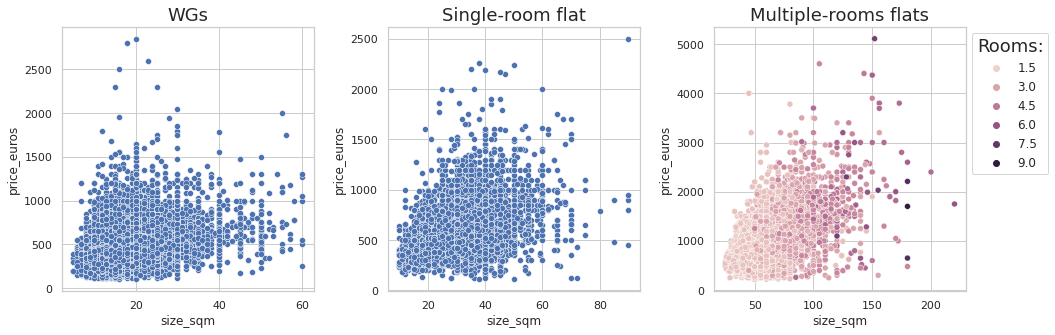

In [7]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.set_theme(style = "whitegrid", font_scale= 1.5)
sns.scatterplot(data = wg_df, y='price_euros',x='size_sqm', ax=ax1).set(title='WGs')
sns.scatterplot(data = singleroom_df, y='price_euros',x='size_sqm', ax=ax2).set(title='Single-room flat')
sns.scatterplot(data = flathouse_df, y='price_euros',x='size_sqm', ax=ax3, hue = 'available_rooms').set(title='Multiple-rooms flats')
ax3.legend(title='Rooms:', fontsize=12, bbox_to_anchor= (1,1))# loc='upper right')
plt.tight_layout();

In [8]:
dayweek_wg_df = wg_df[['url', 'day_of_week_publication']].groupby('day_of_week_publication').count().rename(columns={'url':'count'})
dayweek_wg_df['order'] = [5,1,6,7,4,2,3]
dayweek_wg_df = dayweek_wg_df.sort_values(by = ['order']).drop(['order'], axis=1)
dayweek_wg_df['Percentage'] = dayweek_wg_df['count'].apply(lambda x: round(100*x/sum(dayweek_wg_df['count']),2))
dayweek_wg_df

count  Percentage
day_of_week_publication                   
Mon                       8141       18.68
Tue                       7162       16.43
Wed                       7003       16.07
Thu                       5495       12.61
Fri                       5273       12.10
Sat                       4969       11.40
Sun                       5537       12.71

In [9]:
hourday_wg_df = wg_df[['url', 'published_at']].groupby('published_at').count().rename(columns={'url':'count'})
hourday_wg_df['Percentage'] = hourday_wg_df['count'].apply(lambda x: round(100*x/sum(hourday_wg_df['count']),2))
hourday_wg_df

count  Percentage
published_at                   
0               928        2.92
1               346        1.09
2               171        0.54
3                70        0.22
4                46        0.14
5                57        0.18
6                81        0.25
7               240        0.76
8               612        1.93
9              1147        3.61
10             1537        4.84
11             2031        6.39
12             2196        6.91
13             2213        6.97
14             2149        6.76
15             2094        6.59
16             2170        6.83
17             2124        6.69
18             2220        6.99
19             2067        6.51
20             1956        6.16
21             1994        6.28
22             1898        5.97
23             1424        4.48

In [10]:
city_wg_df = wg_df[['url', 'city']].groupby('city').count().rename(columns={'url':'count'}).sort_values(by = ['count'], ascending=False)
city_wg_df['Percentage'] = city_wg_df['count'].apply(lambda x: round(100*x/sum(city_wg_df['count']),2))
city_wg_df

count  Percentage
city                                
Berlin              6103       14.00
München             4031        9.25
Hamburg             3207        7.36
Stuttgart           2865        6.57
Köln                2552        5.86
Leipzig             1997        4.58
Münster             1977        4.54
Frankfurt am Main   1951        4.48
Karlsruhe           1720        3.95
Würzburg            1408        3.23
Hannover            1349        3.10
Heidelberg          1326        3.04
Aachen              1324        3.04
Bremen              1230        2.82
Mannheim            1203        2.76
Göttingen           1139        2.61
Mainz               1110        2.55
Bonn                1050        2.41
Regensburg           967        2.22
Nürnberg             945        2.17
Düsseldorf           888        2.04
Dresden              854        1.96
Darmstadt            840        1.93
Tübingen             838        1.92
Kiel                 706        1.62

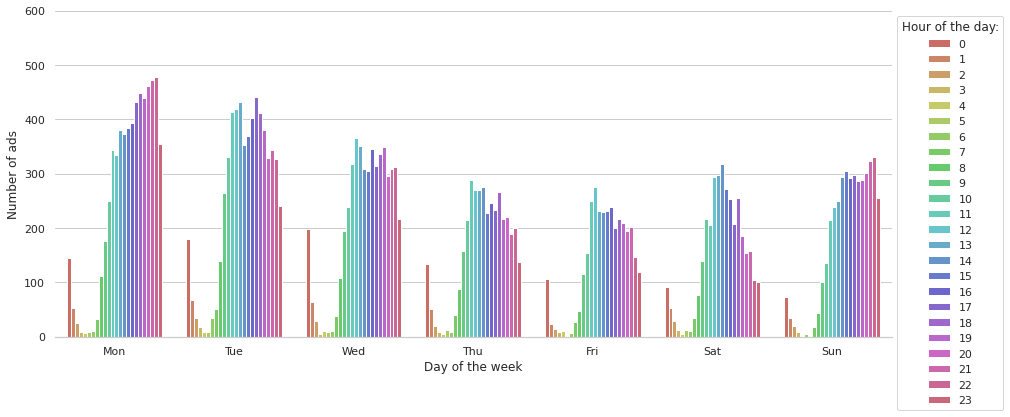

In [11]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax = plt.subplots(figsize=(15,6))

sns.countplot(
    data=wg_df[['day_of_week_publication','published_at']].dropna(axis=0),
    x="day_of_week_publication",
    hue = 'published_at',
    order=['Mon', 'Tue', 'Wed', "Thu", "Fri", "Sat", "Sun"],
    palette='hls', # or husl are exampels of circular color palletes
    ax=ax)
plt.legend(bbox_to_anchor = (1, 1), title = 'Hour of the day:')
sns.despine(top=True,left=True,right=True) # Background grid borders
ax.set(ylim=(0, 600), ylabel="Number of ads", xlabel="Day of the week");

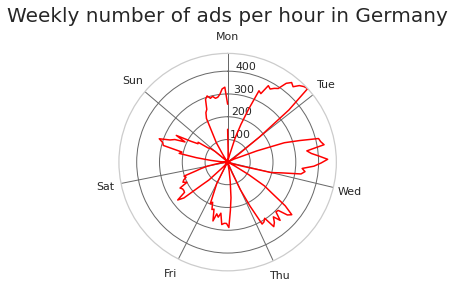

In [12]:
day_week_map = {'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6}
foo = wg_df.copy()
foo['day_week_number'] = foo['day_of_week_publication'].map(day_week_map)
foo = foo.sort_values(by = ['day_week_number'], ascending=True)
foo['week_hour_publication'] = foo['day_week_number']*24 + foo['published_at'] 
foo = foo[['url','week_hour_publication']].dropna(axis=0).groupby(['week_hour_publication']).count().rename(columns = {'url':'count'}).reset_index()



plotting_values = [float(i)*np.pi/180.0 for i in list(np.arange(0, 361, 360/max(foo['week_hour_publication'])))]
mapping_dict = dict(zip(range(0,max([int(item) for item in foo['week_hour_publication']])+1), plotting_values))
foo['week_hour_publication_radians'] = foo['week_hour_publication'].map(mapping_dict)

colors = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

ax = plt.subplot(111, projection='polar')


foo.plot(x='week_hour_publication_radians', y='count', color ='red', ax=ax)


ax.grid(True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


ax.xaxis.set_ticks(plotting_values[::24])
ax.set_xticklabels(days_of_week)
ax.set_xlabel('')

ax.set_rmax(500)
ax.set_rticks([100,200,300,400])
ax.set_rlabel_position(5)  # Rotate labels

ax.get_legend().remove()
#change colors of axis to gray
ax.xaxis.grid(True,color='dimgray',linestyle='-', linewidth = 1)
ax.yaxis.grid(True,color='dimgray',linestyle='-', linewidth = 1)

ax.set_title("Weekly number of ads per hour in Germany", va='bottom', fontsize=20)
ax.margins(0)
plt.show()

''

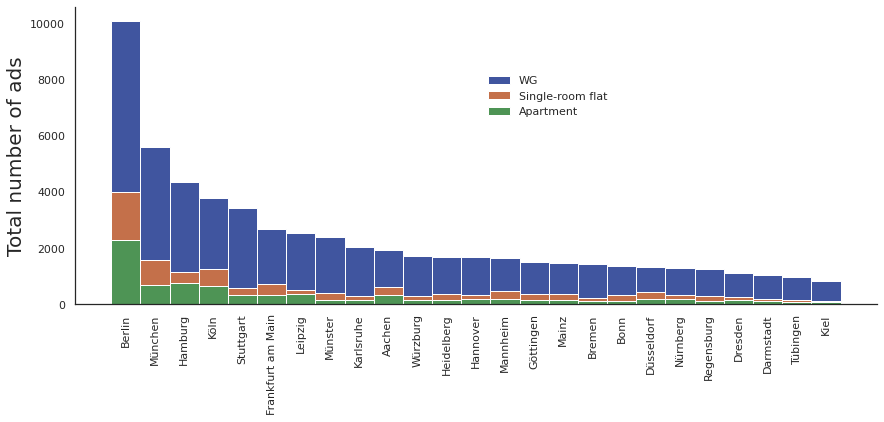

In [13]:
city_ads_df = ads_df[['url', 'city']].groupby('city').count().sort_values(by = ['url'], ascending=False)
reorderlist = list(city_ads_df.index)
ads_df_ordered_counts = ads_df.iloc[pd.Categorical(ads_df.city,reorderlist).argsort()]


sns.set_theme(style = "white", font_scale= 1)
ax = sns.displot(x='city', data=ads_df_ordered_counts, hue='type_offer_simple',
            hue_order=['WG', 'Single-room flat','Apartment'],
#             hue_labels=['WG', 'Single-room flat','Multi'],
            multiple='stack',
            height=5, aspect=10/4,
            palette='dark',
           )

# ax.set(ylim=(0, 8000));
ax.set_xticklabels(rotation = 90)
ax.set_ylabels(label="Total number of ads", fontsize=20)
ax.set_xlabels('', fontsize=20)

sns.move_legend(ax, loc = "upper right", bbox_to_anchor= (0.6,0.8), title = '')
;

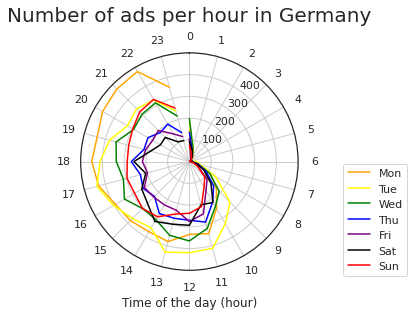

In [14]:
wg_df_time = wg_df[['url', 'day_of_week_publication','published_at']].groupby(['day_of_week_publication','published_at']).count().rename(columns = {'url':'count'}).reset_index()

plotting_values = [float(i)*np.pi/180.0 for i in list(np.arange(0, 360, 360/24))]
mapping_dict = dict(zip(range(0,24), plotting_values))
wg_df_time['published_at_radians'] = wg_df_time.published_at.map(mapping_dict)

colors = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

ax = plt.subplot(111, projection='polar')

for day_i in range(7):
    # Filter day week
    foo = wg_df_time[wg_df_time['day_of_week_publication'] == days_of_week[day_i]]
    foo.plot('published_at_radians', 'count', color = colors[day_i], label = days_of_week[day_i], ax=ax)


ax.grid(True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


ax.xaxis.set_ticks(plotting_values)
ax.set_xticklabels(np.arange(0, 24, 1))
ax.set_xlabel('Time of the day (hour)')

ax.set_rmax(500)
ax.set_rticks([100,200,300,400])
ax.set_rlabel_position(35)  # Rotate labels

# Legend positioning
angle = np.deg2rad(-30)
ax.legend(loc="lower left",
          bbox_to_anchor=(0.75 + np.cos(angle)/2, # Horizontal distance from center
                          .2 + np.sin(angle)/2)) # Vertical distance from center

ax.set_title("Number of ads per hour in Germany", va='bottom', fontsize=20)
plt.show()

''

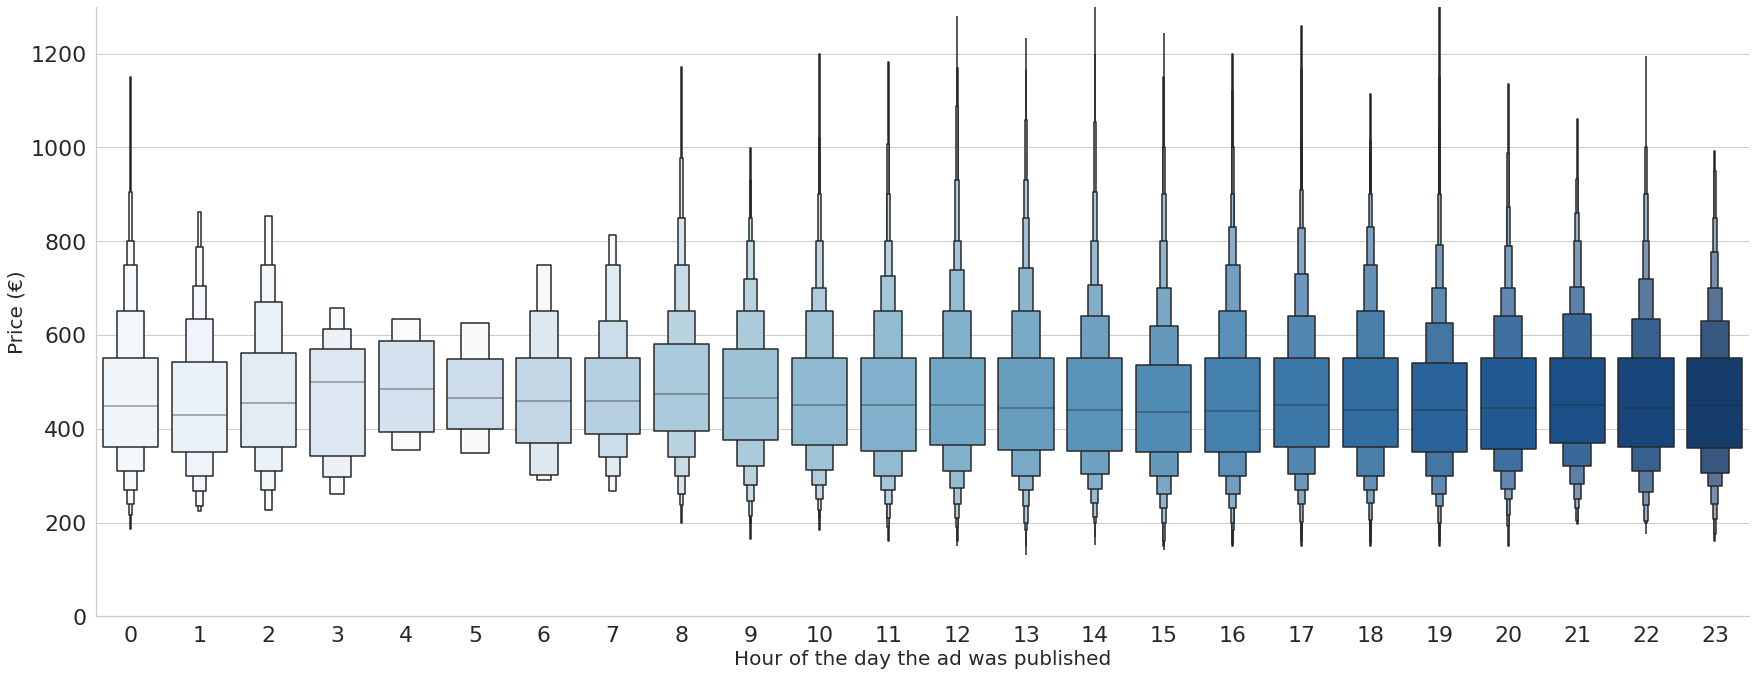

In [15]:
sns.set_theme(style = "whitegrid", font_scale= 2)
ax = sns.catplot(data = wg_df[['published_at','price_euros']].dropna(axis=0), 
                 x = 'published_at', y = 'price_euros',
                 kind='boxen',
                 palette='Blues',
                 height=10, aspect=10/4, showfliers = False)
ax.set(ylim=(0, 1300))
ax.set_ylabels(label="Price (€)", fontsize=20) # not set_label
ax.set_xlabels('Hour of the day the ad was published', fontsize=20) # not set_label
;

''

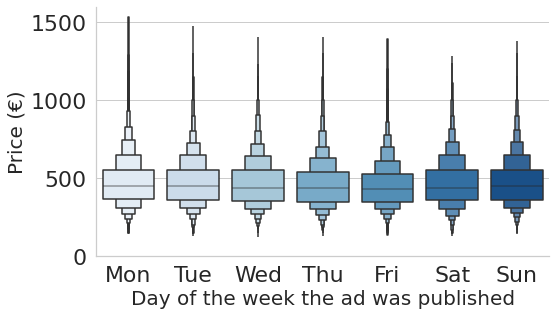

In [16]:
sns.set_theme(style = "whitegrid", font_scale= 2)
ax = sns.catplot(data = wg_df, 
                 x = 'day_of_week_publication', y = 'price_euros',
                 order=['Mon', 'Tue', 'Wed', "Thu", "Fri", "Sat", "Sun"],
                 kind='boxen',
                 palette='Blues',
                 height=5, aspect=10/6, showfliers = False)
ax.set(ylim=(0, 1600))
ax.set_ylabels(label="Price (€)", fontsize=20) # not set_label
ax.set_xlabels('Day of the week the ad was published', fontsize=20) # not set_label
;

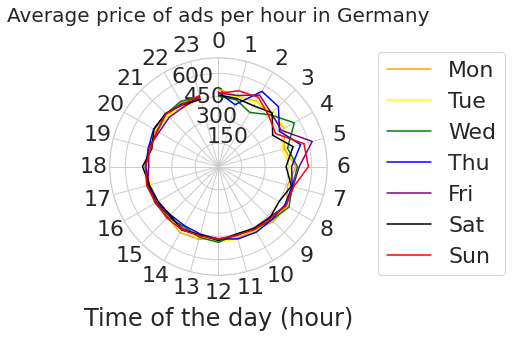

In [17]:
wg_df_time = wg_df[['price_euros', 'day_of_week_publication','published_at']].groupby(['day_of_week_publication','published_at']).mean().reset_index()

plotting_values = [float(i)*np.pi/180.0 for i in list(np.arange(0, 360, 360/24))]
mapping_dict = dict(zip(range(0,24), plotting_values))
wg_df_time['published_at_radians'] = wg_df_time.published_at.map(mapping_dict)

colors = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


sns.set_theme(style = "whitegrid", font_scale= 2)
ax = plt.subplot(111, projection='polar')

for day_i in range(7):
    # Filter day week
    foo = wg_df_time[wg_df_time['day_of_week_publication'] == days_of_week[day_i]]
    foo.plot('published_at_radians', 'price_euros', color = colors[day_i], label = days_of_week[day_i], ax=ax)


ax.grid(True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


ax.xaxis.set_ticks(plotting_values)
ax.set_xticklabels(np.arange(0, 24, 1))
ax.set_xlabel('Time of the day (hour)')

ax.set_rmax(700)
ax.set_rticks([150,300,450,600])  # Move radial labels away from plotted line
ax.set_rlabel_position(-30)  # Rotate labels

# Legend positioning
angle = np.deg2rad(-30)
ax.legend(loc="lower left",
          bbox_to_anchor=(0.75 + np.cos(angle)/2, # Horizontal distance from center
                          .2 + np.sin(angle)/2)) # Vertical distance from center

ax.set_title("Average price of ads per hour in Germany", va='bottom', fontsize=20)
plt.show()

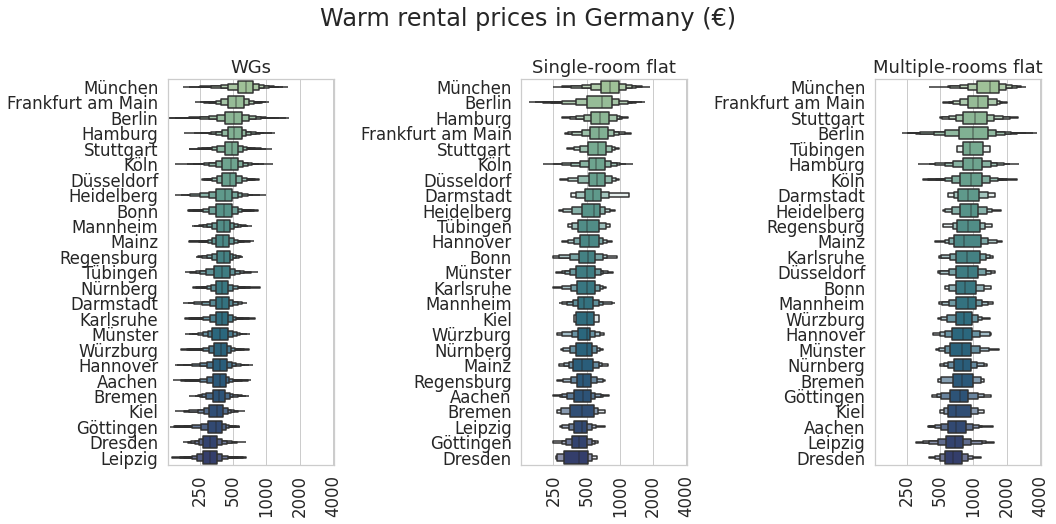

In [18]:
# Finding the order
city_wg_df = wg_df[['price_euros', 'city']].groupby('city').mean().sort_values(by = ['price_euros'], ascending=False)
city_singleroom_df = singleroom_df[['price_euros', 'city']].groupby('city').mean().sort_values(by = ['price_euros'], ascending=False)
city_flathouse_df = flathouse_df[['price_euros', 'city']].groupby('city').mean().sort_values(by = ['price_euros'], ascending=False)

# Log transform prices
wg_df_mod = wg_df.copy()
wg_df_mod['price_euros'] = np.log2(wg_df_mod['price_euros'])

singleroom_df_mod = singleroom_df.copy()
singleroom_df_mod['price_euros'] = np.log2(singleroom_df_mod['price_euros'])

flathouse_df_mod = flathouse_df.copy()
flathouse_df_mod['price_euros'] = np.log2(flathouse_df_mod['price_euros'])

# Figure
sns.set_theme(style = "whitegrid", font_scale= 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 7.5))

sns.boxenplot(data = wg_df_mod, y = 'city', x = 'price_euros',
            order = city_wg_df.index,
            palette='crest', showfliers = False,
            ax=ax1).set(title='WGs')

sns.boxenplot(data = singleroom_df_mod, y = 'city', x = 'price_euros',
            order = city_singleroom_df.index,
            palette='crest', showfliers = False,
            ax=ax2).set(title='Single-room flat')

sns.boxenplot(data = flathouse_df_mod, y = 'city', x = 'price_euros',
            order = city_flathouse_df.index,
            palette='crest', showfliers = False,
            ax=ax3).set(title='Multiple-rooms flat')

ax1.set(xlim=(7, 12), xlabel=None, ylabel=None)
ax1.set_xticks([np.log2(250),np.log2(500),np.log2(1000),np.log2(2000),np.log2(4000)])
ax1.set_xticklabels(rotation = 90, labels =[250,500,1000,2000,4000])


ax2.set(xlim=(7, 12), xlabel=None, ylabel=None)
ax2.set_xticks([np.log2(250),np.log2(500),np.log2(1000),np.log2(2000),np.log2(4000)])
ax2.set_xticklabels(rotation = 90, labels =[250,500,1000,2000,4000])

ax3.set(xlim=(7, 12), xlabel=None, ylabel=None)
ax3.set_xticks([np.log2(250),np.log2(500),np.log2(1000),np.log2(2000),np.log2(4000)])
ax3.set_xticklabels(rotation = 90, labels =[250,500,1000,2000,4000])
fig.suptitle('Warm rental prices in Germany (€)', fontsize=24)

plt.tight_layout();

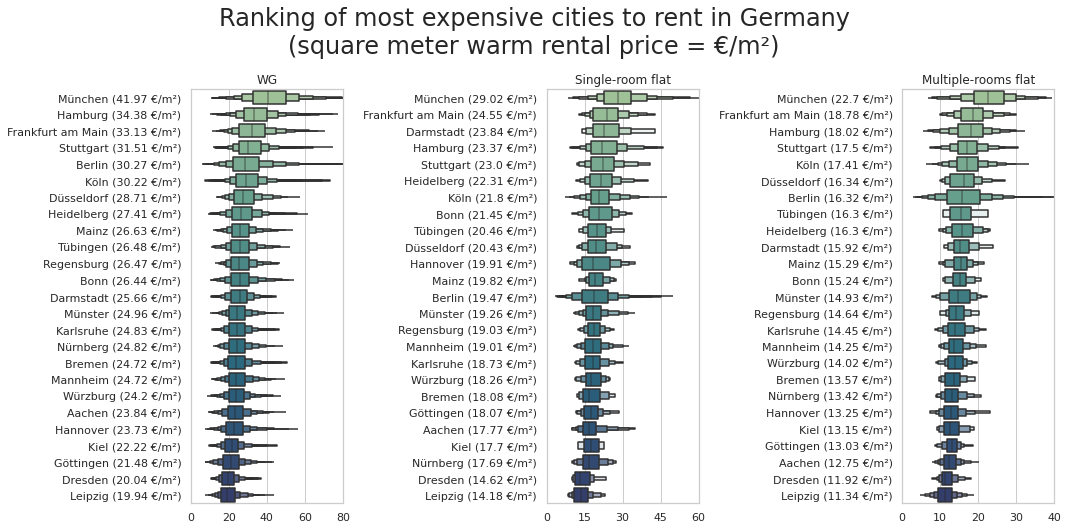

In [19]:
# Finding the order
city_wg_df = wg_df[['price_per_sqm', 'city']].groupby('city').mean().sort_values(by = ['price_per_sqm'], ascending=False)
city_singleroom_df = singleroom_df[['price_per_sqm', 'city']].groupby('city').mean().sort_values(by = ['price_per_sqm'], ascending=False)
city_flathouse_df = flathouse_df[['price_per_sqm', 'city']].groupby('city').mean().sort_values(by = ['price_per_sqm'], ascending=False)

# Log transform prices
# wg_df_mod = wg_df.copy()
# wg_df_mod['price_per_sqm'] = np.log2(wg_df_mod['price_per_sqm'])

# singleroom_df_mod = singleroom_df.copy()
# singleroom_df_mod['price_per_sqm'] = np.log2(singleroom_df_mod['price_per_sqm'])

# flathouse_df_mod = flathouse_df.copy()
# flathouse_df_mod['price_per_sqm'] = np.log2(flathouse_df_mod['price_per_sqm'])

# Figure
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 7.5))

sns.boxenplot(data = wg_df, y = 'city', x = 'price_per_sqm',
            order = city_wg_df.index,
            palette='crest', showfliers = False,
            ax=ax1).set(title='WG')

sns.boxenplot(data = singleroom_df, y = 'city', x = 'price_per_sqm',
            order = city_singleroom_df.index,
            palette='crest', showfliers = False,
            ax=ax2).set(title='Single-room flat')

sns.boxenplot(data = flathouse_df, y = 'city', x = 'price_per_sqm',
            order = city_flathouse_df.index,
            palette='crest', showfliers = False,
            ax=ax3).set(title='Multiple-rooms flat')

ax1.set(xlim=(0, 80), xlabel=None, ylabel=None)
ax1.set_xticks(range(0,81,20))
name_city_price = []

for city in city_wg_df.index:
    name_city_price.append(f'{city} ({round(city_wg_df.loc[city]["price_per_sqm"],2)} €/m²)')
ax1.set_yticks(range(0,25), name_city_price)



ax2.set(xlim=(0, 60), xlabel=None, ylabel=None)
ax2.set_xticks(range(0,61,15))

name_city_price = []
for city in city_singleroom_df.index:
    name_city_price.append(f'{city} ({round(city_singleroom_df.loc[city]["price_per_sqm"],2)} €/m²)')
ax2.set_yticks(range(0,25), name_city_price)



ax3.set(xlim=(0, 40), xlabel=None, ylabel=None)
ax3.set_xticks(range(0,41,10))

name_city_price = []
for city in city_flathouse_df.index:
    name_city_price.append(f'{city} ({round(city_flathouse_df.loc[city]["price_per_sqm"],2)} €/m²)')
ax3.set_yticks(range(0,25), name_city_price)



fig.suptitle('Ranking of most expensive cities to rent in Germany\n(square meter warm rental price = €/m²)', fontsize=24)

plt.tight_layout();

In [20]:
flathouse_df.columns

Index(['id', 'url', 'commercial_landlord', 'title', 'price_euros', 'size_sqm',
       'available_rooms', 'capacity', 'available_spots_wg', 'male_flatmates',
       ...
       'comfort_rivers', 'activities_post', 'comfort_green_parks',
       'comfort_street_motorway', 'sin_degrees_to_centroid',
       'cos_degrees_to_centroid', 'sin_published_at', 'cos_published_at',
       'sin_day_week_int', 'cos_day_week_int'],
      dtype='object', length=125)

''

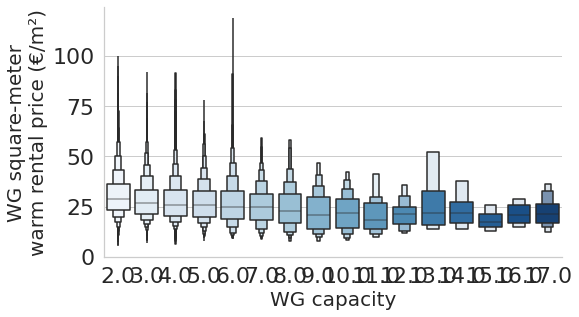

In [21]:
sns.set_theme(style = "whitegrid", font_scale= 2)
ax = sns.catplot(data = wg_df, 
                 x = 'capacity', y = 'price_per_sqm',
                 kind='boxen',
                 palette='Blues',
                 height=5, aspect=10/6, showfliers = False)
# ax.set(ylim=(0, 1600))
ax.set_ylabels(label="WG square-meter\nwarm rental price (€/m²)", fontsize=20) # not set_label
ax.set_xlabels('WG capacity', fontsize=20) # not set_label
;

In [22]:
def create_ridgeline_plot(df = wg_df,
                          column = 'price_euros',
                          factor = 'city',
                          max_x = 1200, min_x = 0,
                          max_y = 0.008, min_y = 0,
                          pal_name = 'crest',
                         title = 'WG rent in Germany,\n rent (€)', unit='€'):
    
    foo_df = df[[column, factor]].groupby(by=factor).mean().sort_values(by = column, ascending=False).reset_index().copy()
    ordered_factors = foo_df[factor].tolist()
    mapping_dict = dict(zip(ordered_factors, range(1,len(ordered_factors)+1,1)))
    # Map city order for plotting
    df['order_factors'] = df[factor].map(mapping_dict)

    # Limit prices for the plot
    df = df[df[column] <= max_x]
    df = df[df[column] >= min_x]

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})  

    # we generate a color palette with Seaborn.color_palette()
    pal = sns.color_palette(palette=pal_name, n_colors=len(ordered_factors))  

    # in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
    g = sns.FacetGrid(df, row='order_factors', hue='order_factors', aspect=10, height=1, palette=pal)

    # then we add the densities kdeplots for each city
    g.map(sns.kdeplot, column,
          bw_adjust=1, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)

    # here we add a white line that represents the contour of each kdeplot
    g.map(sns.kdeplot, column, 
          bw_adjust=1, clip_on=False, 
          color="w", lw=3)

    # here we add a horizontal line for each plot
    g.map(plt.axhline, y=0,
          lw=0.25, clip_on=False)

    # we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
    # notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
    for i, ax in enumerate(g.axes.flat):
        factor_name = list(mapping_dict.keys())[i]
        mean_value = round(float(foo_df[foo_df[factor] == factor_name][column]),2)
        
        ax.text(-(max_x+abs(min_x))/5, max_y/10, # Text location
                f'{factor_name}\nmean = {mean_value} {unit}', # Text label
                fontsize=15,
                color=ax.lines[-1].get_color()) # Text color

    # we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
    g.fig.subplots_adjust(hspace=-0.75)

    # eventually we remove axes titles, yticks and spines
    g.set_titles("")
    g.set(ylabel = '', yticks=[], ylim = (min_y,max_y), xlim = (-(max_x+abs(min_x))/5, max_x))
    g.despine(bottom=True, left=True)

    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.xlabel('', fontsize=20)
    plt.ylabel('')
    g.fig.suptitle(title,
                   ha='center',
                   fontsize=20,
                   fontweight=20);
    
    return g

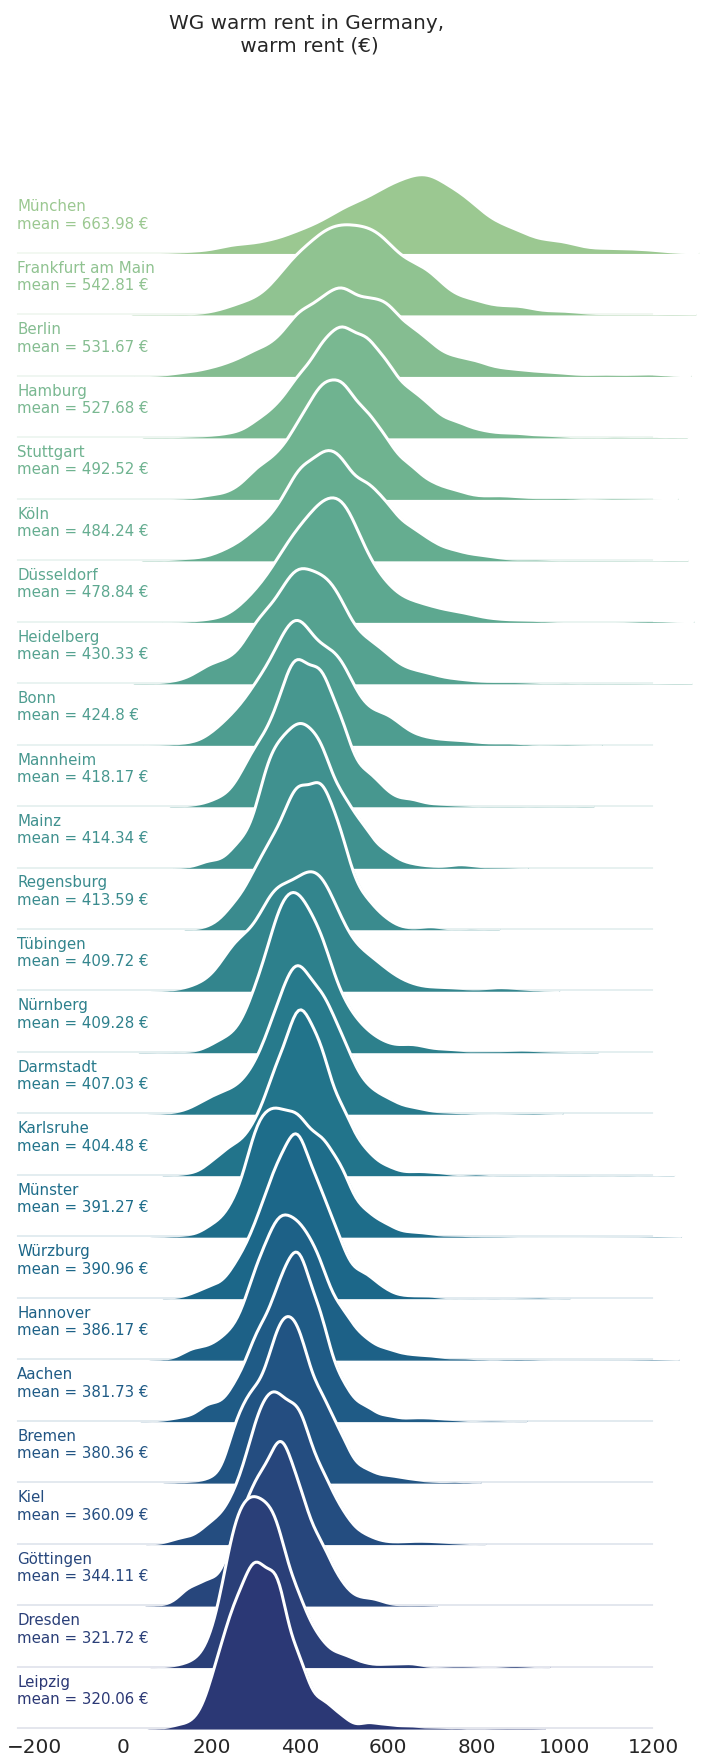

In [23]:
create_ridgeline_plot(df = wg_df,
                          column = 'price_euros',
                          factor = 'city',
                          max_x = 1200, min_x = 0,
                          max_y = 0.008, min_y = 0,
                          pal_name = 'crest',
                         title = 'WG warm rent in Germany,\n warm rent (€)');

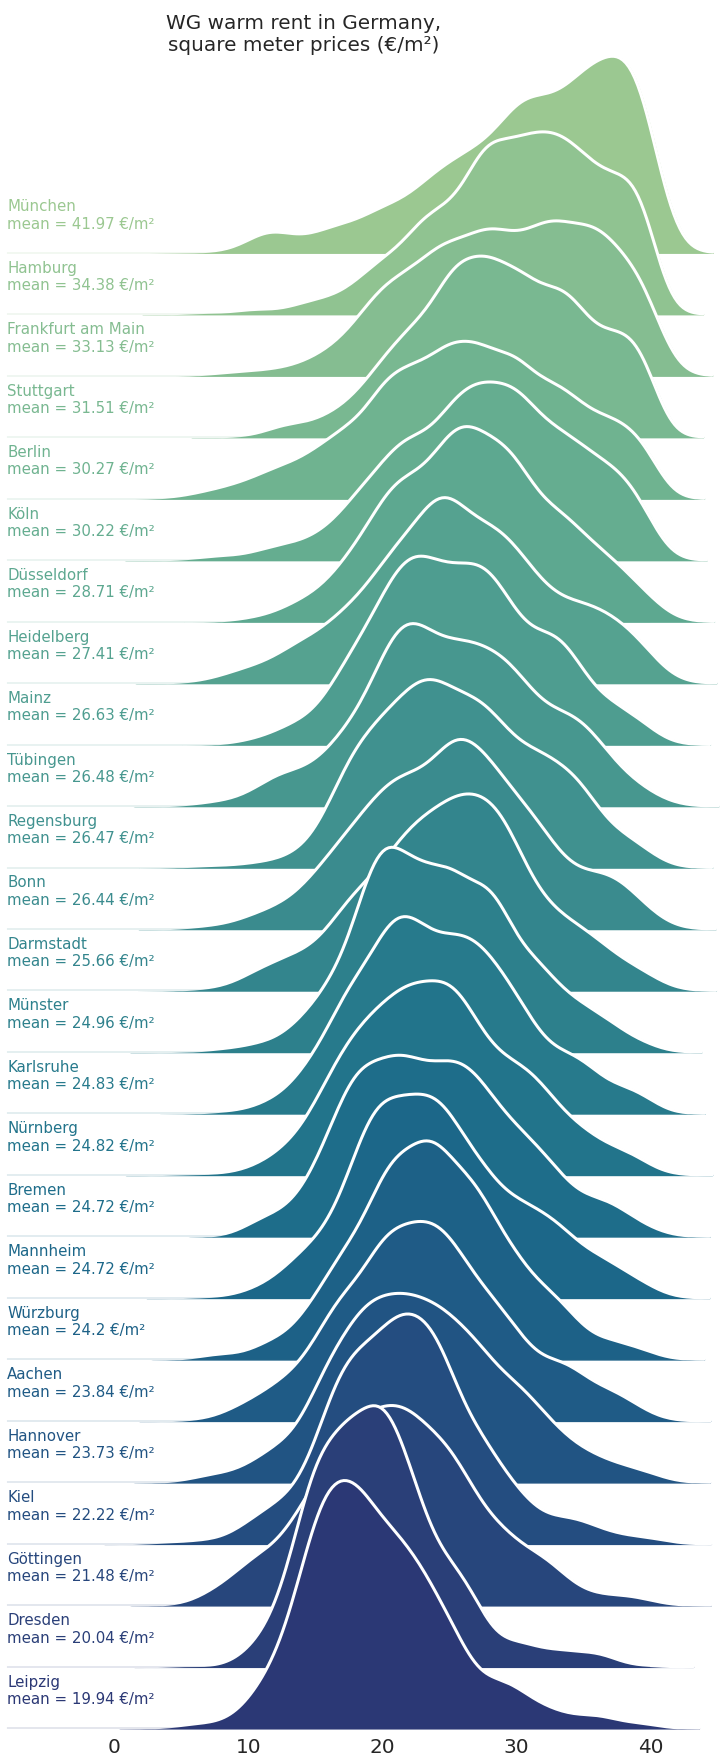

In [24]:
create_ridgeline_plot(df = wg_df,
                          column = 'price_per_sqm',
                          factor = 'city',
                          max_x = 40, min_x = 0,
                          max_y = 0.08, min_y = 0,
                          pal_name = 'crest',
                         title = 'WG warm rent in Germany,\nsquare meter prices (€/m²)', unit = '€/m²');

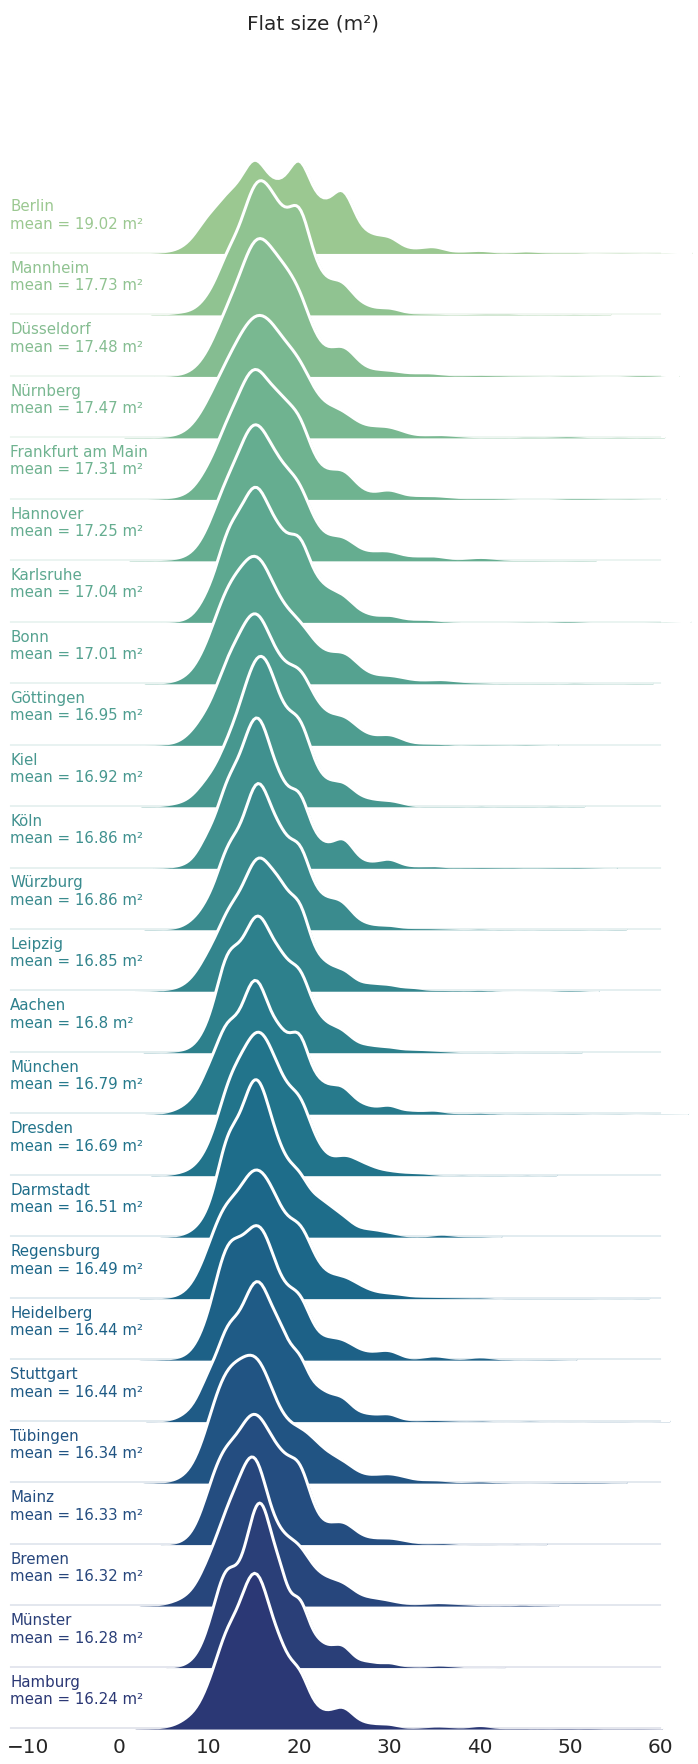

In [25]:
create_ridgeline_plot(df = wg_df,
                          column = 'size_sqm',
                          factor = 'city',
                          max_x = 60, min_x = 0,
                          max_y = 0.182, min_y = 0,
                          pal_name = 'crest',
                         title = 'Flat size (m²)', unit = 'm²');

sns.pairplot(iris, hue="species", palette="Set2", diag_kind="kde", height=2.5)

In [26]:
# Generate tables for plotting
ads_df_grouped = ads_df[['price_per_sqm', 'city', 'type_offer_simple']].groupby(['city','type_offer_simple']).mean().reset_index()
ads_df_grouped = ads_df_grouped.pivot(index='city', columns = 'type_offer_simple', values='price_per_sqm').reset_index()

from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=3)#,
#     subplot_titles=("WG X multi-room flat", "WG X Single-room flat", "multi-room flat X Single-room flat"))

ax1= px.scatter(data_frame = ads_df_grouped, y='Apartment',x='WG', color = 'city')
for index in range(len(ax1['data'])):
    fig.add_trace(ax1['data'][index],
                  row=1, col=1)

ax2= px.scatter(data_frame = ads_df_grouped, y='Single-room flat',x='WG', color = 'city')
for index in range(len(ax2['data'])):
    fig.add_trace(ax2['data'][index],
                  row=1, col=2)

ax3= px.scatter(data_frame = ads_df_grouped, y='Single-room flat',x='Apartment', color = 'city')
for index in range(len(ax3['data'])):
    fig.add_trace(ax3['data'][index],
                  row=1, col=3)

fig.update_layout(height=400, width=1000,
                  title_text="Average square-meter prices in Germany (€/m²)", showlegend=False)

# Update xaxis properties
fig.update_xaxes(title_text="WGs", #range=[15, 45],
                 row=1, col=1)
fig.update_xaxes(title_text="WGs", #range=[15, 45],
                 row=1, col=2)
fig.update_xaxes(title_text="Multi-room flats", #range=[10, 25], 
                 row=1, col=3)

# Update yaxis properties
fig.update_yaxes(title_text="Multi-room flats", #range=[10, 25],
                 row=1, col=1)
fig.update_yaxes(title_text="Single-room flats", #range=[10, 35],
                 row=1, col=2)
fig.update_yaxes(title_text="Single-room flats", #range=[10, 35],
                 row=1, col=3)


fig.show()

In [27]:
# Finding the order
ads_df_grouped = ads_df[['price_per_sqm', 'city', 'type_offer_simple']].groupby(['city','type_offer_simple']).mean().reset_index()
ads_df_grouped = ads_df_grouped.pivot(index='city', columns = 'type_offer_simple', values='price_per_sqm').reset_index()
ads_df_grouped['WGxApartment_ratio'] = ads_df_grouped['WG']/ads_df_grouped['Apartment']
ads_df_grouped['WGxHouse_ratio'] = ads_df_grouped['WG']/ads_df_grouped['House']
ads_df_grouped['WGxSingleroomflat_ratio'] = ads_df_grouped['WG']/ads_df_grouped['Single-room flat']
ads_df_grouped['ApartmentxSingleroomflat_ratio'] = ads_df_grouped['Apartment']/ads_df_grouped['Single-room flat']

# Reorder it following the values of the first value:
ordered_df = ads_df_grouped.sort_values(by = ['WGxApartment_ratio'], ascending=True).copy()
my_range=range(1,len(ordered_df)+1)

# Figure
sns.set_theme(style = "whitegrid", font_scale= 1.5)
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 10))


# The horizontal plot is made using the hline function
ax1.hlines(y=my_range, xmin=ordered_df['WGxSingleroomflat_ratio'], xmax=ordered_df['WGxApartment_ratio'], color='black', alpha=0.2, linewidth = 3)
ax1.scatter(ordered_df['WGxSingleroomflat_ratio'], my_range, color='skyblue', alpha=1, label='Single-room apartment')
ax1.scatter(ordered_df['WGxApartment_ratio'], my_range, color='green', alpha=1 , label='Multi-room apartment')
ax1.legend()
 
# Add title and axis names
ax1.set(title=None, #xlim=(1, 2),
        xlabel='WG rental ratio over flat (in €/m² fold-change)', ylabel=None)
ax1.set_yticks(my_range, ordered_df['city'])

ax1.legend(loc="upper center", bbox_to_anchor=(.5,1.15))

ax1.yaxis.grid(False)#,color='dimgray', linestyle='--', linewidth = 1)
ax1.xaxis.grid(True,color='dimgray', linestyle='--', linewidth = 1, alpha=0.5)



fig.suptitle('Square-meter prices for WGs\ncompared to apartments in Germany', fontsize=24)


# Show the graph
plt.tight_layout()
plt.show();

KeyError: 'House'

In [ ]:
# This part of the code was adapted from: https://juanitorduz.github.io/germany_plots/
import geopandas as gpd
from config.config import ROOT_DIR

In [ ]:
plz_shape_df = gpd.read_file(f'{ROOT_DIR}/housing_crawler/data/germany/plz-5stellig/plz-5stellig.shp', dtype={'plz': str})
# Create feature.
plz_shape_df.head()

In [ ]:
plz_region_df = pd.read_csv(f'{ROOT_DIR}/housing_crawler/data/germany/zuordnung_plz_ort.csv', 
    sep=',', 
    dtype={'plz': str}
)

plz_region_df.drop('osm_id', axis=1, inplace=True)

plz_region_df.head()

In [ ]:
# Merge data.
germany_df = pd.merge(
    left=plz_shape_df, 
    right=plz_region_df, 
    on='plz',
    how='inner'
)

germany_df.drop(['note'], axis=1, inplace=True)

germany_df.head()

In [ ]:
plz_einwohner_df = pd.read_csv(
    f'{ROOT_DIR}/housing_crawler/data/germany/plz_einwohner.csv', 
    sep=',', 
    dtype={'plz': str, 'einwohner': int}
)

plz_einwohner_df.head()

In [ ]:
# Merge data.
germany_df = pd.merge(
    left=germany_df, 
    right=plz_einwohner_df.drop(columns = ['note', 'einwohner', 'qkm']), 
    on='plz',
    how='left'
)

germany_df.head()

In [ ]:
import folium
from folium.plugins import HeatMap, Fullscreen
import branca.colormap
from collections import defaultdict
from folium import GeoJson, Marker
from shapely.ops import unary_union
from shapely.geometry import Polygon
from housing_crawler.params import dict_city_number_wggesucht


In [ ]:
def prepare_df_for_merge_plz(df, tag):
    
    # Mean price per PLZ
    df_plz = df[['price_per_sqm', 'zip_code']].groupby(['zip_code']).mean().reset_index()
    df_plz['zip_code'] = df_plz['zip_code'].astype('int64')
    df_plz['price_per_sqm'] = round(df_plz['price_per_sqm'],2)
    df_plz = df_plz.rename(columns = {'zip_code':'plz', 'price_per_sqm':f'price_per_sqm_{tag}'})
    
    # SD price per PLZ
    df_plz_std = df[['price_per_sqm', 'zip_code']].groupby(['zip_code']).std().reset_index()
    df_plz_std['price_per_sqm'] = round(df_plz_std['price_per_sqm'],1)
    df_plz_std = df_plz_std.rename(columns = {'zip_code':'plz', 'price_per_sqm':f'std_{tag}'})
    df_plz = pd.merge(left=df_plz, right=df_plz_std, on='plz', how='left')
    
    # Count of ads per PLZ
    df_plz_count = df[['price_per_sqm', 'zip_code']].groupby(['zip_code']).count().reset_index()
    df_plz_count = df_plz_count.rename(columns = {'zip_code':'plz', 'price_per_sqm':f'count_{tag}'})
    df_plz = pd.merge(left=df_plz, right=df_plz_count, on='plz', how='left')
    
    return df_plz
wg_df_plz = prepare_df_for_merge_plz(df = wg_df, tag = 'wg')
singleroom_df_plz = prepare_df_for_merge_plz(df = singleroom_df, tag = 'single')
flathouse_df_plz = prepare_df_for_merge_plz(df = flathouse_df, tag = 'multi')

In [ ]:
cities_df = germany_df[germany_df['ort'].isin(list(dict_city_number_wggesucht.keys()))]
cities_df['plz'] = cities_df['plz'].astype('int64')
# Filter out PLZ 86692 that ends up in the data because there is a second city called Münster in Bavaria
cities_df = cities_df[cities_df['plz'] != 86692]


# Sequential merging
cities_df = pd.merge(left=pd.merge(left=pd.merge(left=cities_df,
                                                 right=flathouse_df_plz, on='plz', how='left'),
                                   right=singleroom_df_plz, on='plz', how='left'),
                     right=wg_df_plz, on='plz', how='left')

# Create value for coloring and remove plz without info so they are not plotted
cities_df['mean_for_color'] = round(cities_df[['price_per_sqm_wg', 'price_per_sqm_single', 'price_per_sqm_multi']].mean(axis=1),2)
# cities_df = cities_df[~cities_df['mean_for_color'].isnull()].reset_index(drop=True)
# cities_df = cities_df['mean_for_color'].fillna(-1)
cities_df

In [ ]:
from geojson import dump

def get_border_area(df, area, save = False):
    '''
    Returns the border of a specified region in Germany
    '''
    ## Filter df accordingly
    # Area whole country
    if area.lower() == 'germany':
        if save:
            with open(f'{ROOT_DIR}/housing_crawler/data/germany/{standardize_characters(area)}_border.geojson', 'w') as f:
                dump(border, f)
        return unary_union(germany_df['geometry'])
        
    # First search term in bundesland column, if not found search ort names
    df_filtered = df[df['ort'] == area]
    save_at = f'{ROOT_DIR}/housing_crawler/data/{standardize_characters(area)}'
    
    if len(df_filtered) == 0:
        df_filtered = df[df['bundesland'] == area]
        save_at = f'{ROOT_DIR}/housing_crawler/data/germany/bundeslaender'

        
    # Some cities like Münster and Hamburg have weird borders. Exclude the weird parts
    if area.lower() == 'münster': # Filter by being in the correct estate
        df_filtered = df_filtered[df_filtered['bundesland'] == 'Nordrhein-Westfalen']
        
    if area.lower() == 'hamburg': # Filter by tiles inside box around Hamburg
        lon_point_list = [9.62, 10.35, 10.35, 9.62, 9.62]
        lat_point_list = [53.76, 53.76, 53.36, 53.36, 53.76]
        polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
        df_filtered = df_filtered.loc[df_filtered.within(polygon_geom)]
        
    if area.lower() == 'bremen': # Filter by tiles inside box around Hamburg
        lon_point_list = [8.43, 9.04, 9.04, 8.43, 8.43]
        lat_point_list = [53.23, 53.23, 53.0, 53.0, 53.23]
        polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
        df_filtered = df_filtered.loc[df_filtered.within(polygon_geom)]

    
    # Create border by uniting all sub-polygons
    border = unary_union(df_filtered['geometry'])
    
    if save:
        with open(f'{save_at}/{standardize_characters(area)}_border.geojson', 'w') as f:
            dump(border, f)
    
    return border

for area in list(dict_city_number_wggesucht.keys()):    
    get_border_area(df=germany_df, area=area, save = True)
    
for area in list(set(germany_df['bundesland'])):    
    get_border_area(df=germany_df, area=area, save = True)

In [ ]:
########### Create the map
mapObj = folium.Map(location=(51.1657, 10.4515), zoom_start=6, max_zoom = 18, width='100%', height='100%', tiles = 'cartodbpositron')

# folium.TileLayer('Stamen Terrain').add_to(mapObj)
# folium.TileLayer('Stamen Toner').add_to(mapObj)
# folium.TileLayer('Stamen Water Color').add_to(mapObj)
folium.TileLayer('openstreetmap').add_to(mapObj)
# folium.TileLayer('cartodbdark_matter').add_to(mapObj)


########### Draw borders
# Add german states border
feature_group = folium.FeatureGroup('Bundesländer borders')
for area in list(set(germany_df['bundesland'])):
    if area not in list(dict_city_number_wggesucht.keys()): # exclude city-estates
        feature_group.add_child(GeoJson(data = open(f'{ROOT_DIR}/housing_crawler/data/germany/bundeslaender/{standardize_characters(area)}_border.geojson', "r", encoding="utf-8-sig").read(),
                name=area,
                show=True,
                style_function=lambda x:{'fillColor': 'transparent','color': 'black', 'weight':0.5},
                zoom_on_click=False))
feature_group.add_to(mapObj)
    
    
# Add cities borders
feature_group = folium.FeatureGroup('City borders')
feature_group_markers = folium.FeatureGroup('City markers')
for area in list(dict_city_number_wggesucht.keys()):    
    feature_group.add_child(GeoJson(data = open(f'{ROOT_DIR}/housing_crawler/data/{standardize_characters(area)}/{standardize_characters(area)}_border.geojson', "r", encoding="utf-8-sig").read(),
                                    name=area,
                                    show=True,
                                    style_function=lambda x:{'fillColor': 'transparent','color': 'black', 'weight':2},
                                    zoom_on_click=True))
    
    gdp = gpd.read_file(f'{ROOT_DIR}/housing_crawler/data/{standardize_characters(area)}/{standardize_characters(area)}_border.geojson')
    centroid = gdp.to_crs('+proj=cea').centroid.to_crs(gdp.crs)
    centroid = list(centroid[0].coords)[0]
    feature_group_markers.add_child(Marker(location=[centroid[1], centroid[0]], tooltip=area,
                                    zoom_on_click=True,
#                                    icon=folium.DivIcon(html=f"""<b>{area}</b>""",
#                                                        class_name="mapText"),
                                   fill_color='#132b5e', num_sides=3, radius=10))
feature_group.add_to(mapObj)
feature_group_markers.add_to(mapObj)


########### PLZ color mapping
## Prep plotting df
plotting_df = cities_df.copy()
plotting_df['plz'] = plotting_df['plz'].astype('str')
for tag in ['wg', 'single','multi']:
    plotting_df[tag] = plotting_df.apply(lambda x: f"{x[f'price_per_sqm_{tag}']} \u00B1{x[f'std_{tag}']} €/m² / {0 if x[f'count_{tag}'] != x[f'count_{tag}'] else int(x[f'count_{tag}'])} ads", axis=1)

colors = ['#225ea8',
          '#1d91c0',
          '#41b6c4',
          '#7fcdbb',
          '#c7e9b4',
          '#edf8b1',
          '#ffffd9'
         ]
colormap = branca.colormap.LinearColormap(colors=colors, index= np.arange(10, 60, 50/len(colors)), vmin=10, vmax=60, caption='Average WG rental price (€/m²)')
colormap.to_step(1000).add_to(mapObj)

def style_fn(feature):
    color = 'grey' if pd.isnull(feature["properties"]["price_per_sqm_wg"]) else colormap(feature["properties"]["price_per_sqm_wg"])

    ss = {
        "fillColor": color,
        'fillOpacity':0.5,
        'color': 'black',
        'weight': 0.25
    }
    return ss


folium.GeoJson(
    plotting_df.to_json(),
    name='Rent price (€/m²)',
    show=True,
    style_function=style_fn,
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        # TO DO edits content columns to display text as wanted
        fields=['ort', 'plz', 'wg', 'single', 'multi'],
        aliases=['City:', 'PLZ:', 'WGs:', 'Single-room flats:', 'Multi-room flats:'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
        localize=True
    ),
).add_to(mapObj)


########### Display settings
folium.LayerControl().add_to(mapObj)
Fullscreen(position='topleft',
           title='Full Screen',
           title_cancel='Exit Full Screen',
           force_separate_button=False).add_to(mapObj)

# mapObj.save(outfile= "test.html")
mapObj